# Plan

### Const
* n - number of points
* gamma
* C : k = C /gamma**2
* no_of_levels : number of levels used in algorithm
### Two dictionaries, from balls to points and from points to balls
* Keys to points: from 0 to n
* keys for balls: A tuple (from, to) which are between 0 and 1

### Arrays for points
* poisson: from point to random in [0,1]
* order: argsort of poisson
* QA: label {-1,+1} associated with point
* Q: set of points that have been queried so far
* yl: list of arrays. For each level list of point labels -10: !, -1,0,+1, 10:initial

### Dict for balls
* Blabel: 10 = initial (not available), -1,0,+1
* counts = number of +1 and -1 answers for queries in ball.
* B2level = the level to which the ball belongs

### List for levels
* Levels: a list of (list of balls in level)
* Ul : A list of (list of points) defining the uncertainty region

# Setup

In [1]:
%pylab inline
from numpy.random import uniform

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
gamma=0.2 ## minimal distinction
n=2000 ## number of points
C=1
k=round(C/gamma**2) ## number of queries needed to identify polarity 
C1=4   #a factor to multiply tau for focused

In [3]:
no_of_levels=8

poisson=uniform(size=n)
order = argsort(poisson)
points = array(range(n))
points = points[order]
Q=zeros(n)

yl=[10*ones(n) for i in range(no_of_levels)]

points[:10]

array([1541, 1207, 1088, 1542,    9, 1061, 1173, 1360, 1014, 1572])

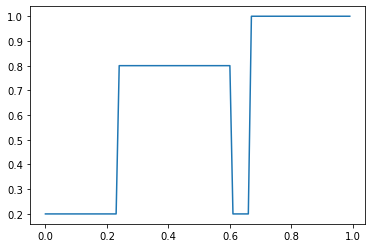

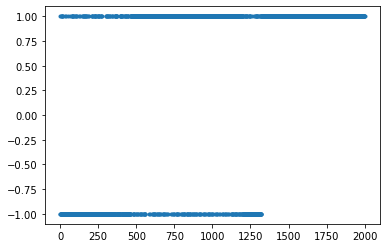

In [4]:
def cond1(x):
    if x>0.66: return 1
    elif x>0.6: return 0.2
    elif x>0.23: return 0.8
    else: return 0.2

def cond2(x):
    if x>0.6: return 0.8
    else: return 0.2
    
def cond3(x):
    return x

def cond4(x):
    if x<0.26 and x>0.2: return 0.9
    else: return 0.1

cond=cond1
    
X=list(arange(0,1,0.01))

plot(X, [cond(x) for x in X])

QA=[]
for p in range(n):
    a=cond(p/n)
    l=uniform(0,1)<a
    if l: l=1
    else: l=-1
    QA.append(l)
QA=array(QA)
figure()
plot(range(n),QA,'.')

## Define balls

In [5]:
Balls2Points={}
Points2Balls={}

Blabel={}
counts={}
B2level={}
def addToDicts(ball,l):
    List=range(round(ball[0]*n),round(ball[1]*n))
    Balls2Points[ball]=List
    Blabel[ball]=10
    counts[ball]=[0,0]
    B2level[ball]=l
    for p in List:
        if p in Points2Balls:
            Points2Balls[p].append(ball)
        else:
            Points2Balls[p]=[ball]
            
#addToDicts((0.1,0.101))
#Balls2Points, Points2Balls

Levels=[]
for l in range(0,no_of_levels):
    if l==0:
        Ul=[points]
    else:
        Ul.append([])
    
    List=[]
    s=1/(2**(l+1))
    for x in arange(0,1-s+0.000001,s/2):
        ball = (x,x+s)
        addToDicts(ball,l)
        List+=[ball]
    Levels+=[List]
print('Levels=\n',Levels)
print('Ul[0]=\n',Ul[0][:10])
print('Balls2Points=\n',Balls2Points)
#print('Points2Balls=\n',Points2Balls)
print('Blabel=\n',Blabel)
print('B2level=\n',B2level)

Levels=
 [[(0.0, 0.5), (0.25, 0.75), (0.5, 1.0)], [(0.0, 0.25), (0.125, 0.375), (0.25, 0.5), (0.375, 0.625), (0.5, 0.75), (0.625, 0.875), (0.75, 1.0)], [(0.0, 0.125), (0.0625, 0.1875), (0.125, 0.25), (0.1875, 0.3125), (0.25, 0.375), (0.3125, 0.4375), (0.375, 0.5), (0.4375, 0.5625), (0.5, 0.625), (0.5625, 0.6875), (0.625, 0.75), (0.6875, 0.8125), (0.75, 0.875), (0.8125, 0.9375), (0.875, 1.0)], [(0.0, 0.0625), (0.03125, 0.09375), (0.0625, 0.125), (0.09375, 0.15625), (0.125, 0.1875), (0.15625, 0.21875), (0.1875, 0.25), (0.21875, 0.28125), (0.25, 0.3125), (0.28125, 0.34375), (0.3125, 0.375), (0.34375, 0.40625), (0.375, 0.4375), (0.40625, 0.46875), (0.4375, 0.5), (0.46875, 0.53125), (0.5, 0.5625), (0.53125, 0.59375), (0.5625, 0.625), (0.59375, 0.65625), (0.625, 0.6875), (0.65625, 0.71875), (0.6875, 0.75), (0.71875, 0.78125), (0.75, 0.8125), (0.78125, 0.84375), (0.8125, 0.875), (0.84375, 0.90625), (0.875, 0.9375), (0.90625, 0.96875), (0.9375, 1.0)], [(0.0, 0.03125), (0.015625, 0.046875), (0.

# Algorithm

 1. Search over levels to find Ul that is not empty (initially, level 0)
 2. Sample focused
 3. Sample background
 4. Update bias estimates
 5. Update PL_l
 6. Update yl
 7. update Ul

## Functions

In [6]:
global S
def computeS(level,U):
    global S
    S=set()
    for p in U:
        B=Points2Balls[p]
        for b in B:
            if B2level[b] != level:
                continue
            S=S|set(Balls2Points[b])
    L=array(list(S))
    if L.shape[0]==0:
        return array([])
    Pois=poisson[L]
    O=argsort(Pois)
    #print(O,L)
    L=L[O]
    #print(f'computeS: level={level}, len(S)={len(S)}')
    return L

In [7]:
def ChooseQuery(S,tau):
    # print('tau=',tau)
    if len(S)==0:
        return None
    O=argsort(poisson[S])
    S=S[O]
    for s in S:
        if Q[s]==0 and poisson[s]<=tau:
            Q[s]=1
            return s
    return None
    # print('ChooseQuery could not find anything')

In [8]:
def makeQueries(Ul,level):
    bquery = ChooseQuery(points,1)
    S=computeS(level,Ul[level])    #compute the set S from Ul[level]
    fquery=ChooseQuery(S,(2**(level+2)*k)/n)
    qpair=(fquery,bquery)
    #print('qpair=',qpair)
    return qpair

def UpdateBalls(qpair):
    #update ball counts, estimate eta, update ball labels
    updated_balls=[]
    for i in range(2):
        p=qpair[i]
        if p is None:
            continue
        l=QA[p]
        B=Points2Balls[p]
        
        # Set balls that have at least k points
        for b in B:
            if Blabel[b]!=10:  # ball label already fixed
                continue
            
            c=counts[b]
            if l==+1: c[1]+=1
            else: c[0]+=1
            s=sum(c)
            if s < k: # not enough examples
                continue
            ## Set label of ball
            updated_balls.append(b)
            eta=(c[1]-c[0])/(c[1]+c[0])
            #print(eta)
            if eta > gamma:
                Blabel[b]=1
            elif eta<-gamma:
                Blabel[b]=-1
            else:
                Blabel[b]=0
    #print(counts)

    return updated_balls

In [9]:
from functools import cmp_to_key

def calc_PL_yl():
    PL=[]
    for j in range(no_of_levels):
        P=[]
        for i in range(n):
            P.append(set([]))
        PL.append(P)

    dlists={}
    for p in range(n):
        balls=Points2Balls[p]
        for l in range(no_of_levels): #go from large balls to small ones
            # find pointXlevel for which all of the balls containing the point are available
            ## check if level covered
            covered=True
            for b in balls:
                if B2level[b]==l and Blabel[b]==10:
                    covered=False
                    break
            if not covered:
                continue  # to next levelxpoint

            ## remove undefined
            dballs=[]
            for b in balls:
                if Blabel[b]!=10 and B2level[b] <= l:
                    dballs.append(b)
                    dlists[b]=set(Balls2Points[b])

            for b1 in dballs:
                s1=Blabel[b1]
                if abs(s1)==1:
                    s=s1
                    for b2 in dballs:
                        if b1==b2: 
                            continue
                        s2=Blabel[b2]
                        if dlists[b2].issubset(dlists[b1]):
                            s=-10
                else:
                    s=-10


                if s!=-10:
                    PL[l][p].add(s)

            if PL[l][p]==set([-1]): yl[l][p]=-1
            elif PL[l][p]==set([1]): yl[l][p]=1
            elif PL[l][p]==set([1,-1]): yl[l][p]=-10
            elif PL[l][p]==set([]): yl[l][p]=0
            else:
                print('bad PL=',PL[l][p])

# Main Loop

In [10]:
Q_=[]
corr_=[]
S_=[]

In [11]:
for i in range(500):
    print(i,end="\r")
    #find non-empty Ul
    for level in range(len(Ul)):
        if len(Ul[level])>0:
            break
    
    qpair=makeQueries(Ul,level)
    UB=UpdateBalls(qpair)
    #print('len(S)=',len(S))
    S_.append(len(S))
    #print('number of queries=',sum(Q))
    #for l in range(no_of_levels):
    #    print(f'Blabel, level={l}: ',end="")
    #    for b in Levels[l]:
    #        print(f'{Blabel[b]}, ',end="")
    #    print()
    calc_PL_yl()
    #compute combined prediction and correlation with training labels
    prediction=zeros(n)
    corr=0
    for p in range(n):
        for l in range(no_of_levels-1,0,-1):
            if  abs(yl[l][p])==1:
                prediction[p]=yl[l][p]
                break
        corr+=prediction[p]*QA[p]
    corr=corr/n
    #print(f'i={i}, Queries={sum(Q)}, correlation={corr}')
    corr_.append(corr)
    Q_.append(sum(Q))
            

    ## Update Ul    
    New_Ul=[]    
    for l in range(no_of_levels):
        U=[]
        if l==0:
            for p in points:
                if yl[0][p]==10:
                    U.append(p)
        else:
            for p in points:
                if yl[l-1][p]==-10 and yl[l][p]==10:
                    U.append(p)
        #print(f'len Ul[{l}] = {len(U)}')
        New_Ul.append(U)
    Ul=New_Ul
            
#            
                
        
    

In [12]:
sum(Q),n

(602.0, 2000)

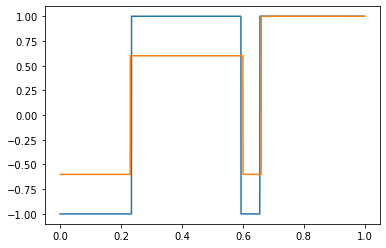

In [13]:
x=arange(0,1,1/n)
plot(x,prediction)
plot(x,[2*cond(y)-1 for y in x])

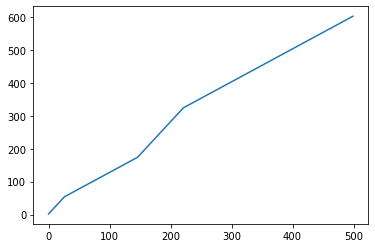

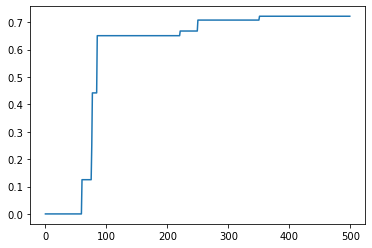

In [14]:
plot(Q_)
figure()
plot(corr_)

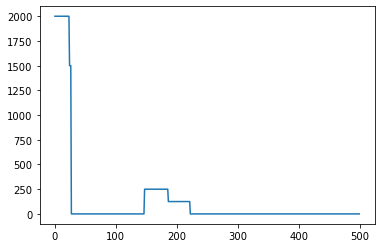

In [22]:
plot(S_)

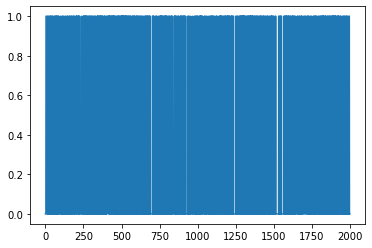

In [16]:
plot(Q)

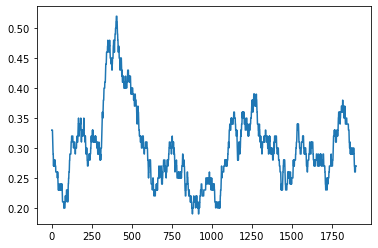

In [17]:
# Define the window size for the moving average
window_size = 100

# Compute the moving average using `np.convolve`
smoothed_arr = np.convolve(Q, np.ones(window_size) / window_size, mode='valid')

plot(smoothed_arr)
